<a href="https://colab.research.google.com/github/aizatulin69/goit-ds-hw-12/blob/main/Hw12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

In [225]:
num_classes = 10
num_features = 784
learning_rate = 0.0005
training_steps = 5000
batch_size = 256
display_step = 50

n_hidden_1 = 512
n_hidden_2 = 512
n_hidden_3 = 256

In [226]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [227]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1, name="layer1")
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="layer2")
        self.layer3 = DenseLayer(n_hidden_2, n_hidden_3, name="layer3")
        self.out = DenseLayer(n_hidden_3, num_classes, name="out")

    def __call__(self, x, training=False):
        x = self.layer1(x, activation=0)
        x = self.layer2(x, activation=0)
        x = self.layer3(x, activation=0)
        x = self.out(x, activation=1)
        return x

In [228]:
def cross_entropy(y_pred, y_true, model=None, l2_lambda=0.001):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    ce_loss = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

    if model is not None:
        l2_loss = sum([tf.nn.l2_loss(var) for var in model.trainable_variables])
        return ce_loss + l2_lambda * l2_loss

    return ce_loss

def accuracy(y_pred, y_true):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int64)
    return tf.reduce_mean(tf.cast(tf.equal(y_pred_labels, y_true), tf.float32))

In [229]:
neural_net = NN(name="fashion_mnist")


def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.Adam(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x, training=True)
        loss = cross_entropy(pred, output_y)

    params = neural_net.trainable_variables
    grads = g.gradient(loss, params)
    optimizer.apply_gradients(zip(grads, params))

In [230]:
loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x, training=False)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss.numpy())
        accuracy_history.append(acc.numpy())
        print(f"step: {step}, loss: {loss.numpy():.4f}, accuracy: {acc.numpy():.4f}")

step: 50, loss: 464.1633, accuracy: 0.5977
step: 100, loss: 286.9352, accuracy: 0.7344
step: 150, loss: 204.9145, accuracy: 0.7930
step: 200, loss: 187.5543, accuracy: 0.7930
step: 250, loss: 217.4310, accuracy: 0.7617
step: 300, loss: 188.7807, accuracy: 0.7852
step: 350, loss: 174.4794, accuracy: 0.7969
step: 400, loss: 116.2908, accuracy: 0.8281
step: 450, loss: 166.0432, accuracy: 0.8008
step: 500, loss: 114.2845, accuracy: 0.8594
step: 550, loss: 124.3981, accuracy: 0.8438
step: 600, loss: 173.7748, accuracy: 0.7852
step: 650, loss: 126.4393, accuracy: 0.8594
step: 700, loss: 98.3206, accuracy: 0.8711
step: 750, loss: 139.5217, accuracy: 0.8242
step: 800, loss: 164.1954, accuracy: 0.8398
step: 850, loss: 79.5436, accuracy: 0.9062
step: 900, loss: 87.6200, accuracy: 0.8906
step: 950, loss: 143.4314, accuracy: 0.8203
step: 1000, loss: 123.4273, accuracy: 0.8711
step: 1050, loss: 122.5542, accuracy: 0.8516
step: 1100, loss: 77.9183, accuracy: 0.9141
step: 1150, loss: 86.1982, accurac

In [231]:
pred_test = neural_net(x_test)
test_accuracy = accuracy(pred_test, y_test)
print(f"Точність на тестових даних: {test_accuracy.numpy():.4f}")

Точність на тестових даних: 0.8306


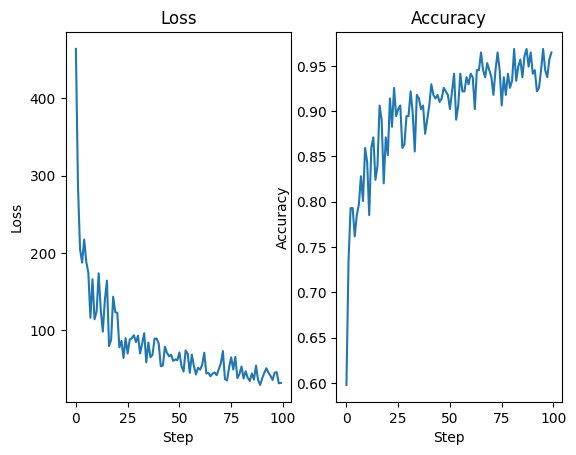

In [232]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title("Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")

plt.show()

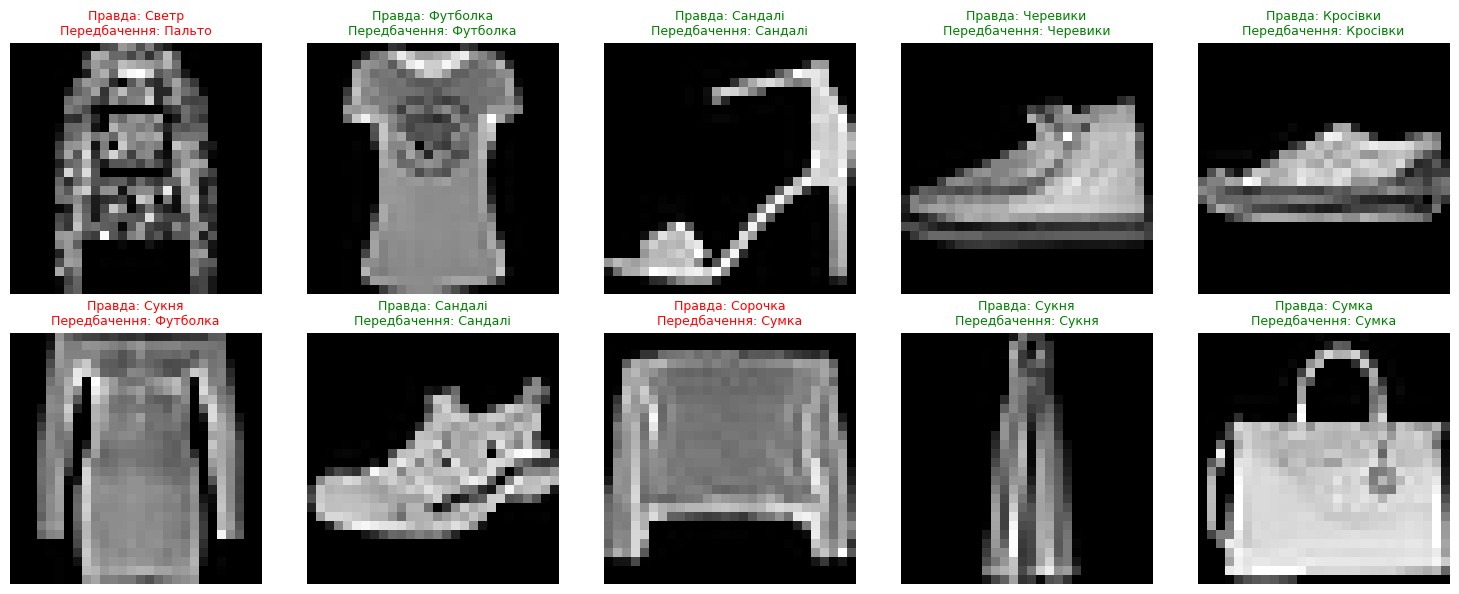


Висновок: Нейромережа правильно розпізнала 7 з 10 зображень (70% точність)
Кількість помилок: 3


In [244]:
# Названия классов Fashion MNIST
class_names = ['Футболка', 'Штани', 'Светр', 'Сукня', 'Пальто',
               'Сандалі', 'Сорочка', 'Кросівки', 'Сумка', 'Черевики']

random_indices = random.sample(range(len(x_test)), 10)

predictions = neural_net(x_test, training=False)
pred_labels = tf.argmax(predictions, axis=1).numpy()

plt.figure(figsize=(15, 6))
correct_count = 0

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    image = x_test[idx].reshape(28, 28)
    plt.imshow(image, cmap='gray')

    true_label = y_test[idx]
    predicted_label = pred_labels[idx]

    is_correct = (true_label == predicted_label)
    if is_correct:
        correct_count += 1
        color = 'green'
    else:
        color = 'red'

    plt.title(f'Правда: {class_names[true_label]}\nПередбачення: {class_names[predicted_label]}',
              color=color, fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nВисновок: Нейромережа правильно розпізнала {correct_count} з 10 зображень ({correct_count*10}% точність)")
print(f"Кількість помилок: {10 - correct_count}")